# SVM
5月2日（土）

## データセット

In [2]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

iris = load_iris()
target = iris.target
y = target[target!=2]
# 2つだけ
X = iris.data[target != 2][:, :2]

plt.scatter(X[y==0][:, 0], X[y==0][:, 1], color='red')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='blue')

# sklearnのsvm

In [3]:
from sklearn.svm import SVC

clf = SVC(random_state=42, kernel='linear')
clf.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [4]:
clf.dual_coef_

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -0.75200423,  1.        ,  1.        ,
         1.        ,  0.75200423,  1.        ,  1.        ,  1.        ,
         1.        ]])

In [5]:
intercept = clf.intercept_

In [6]:
coef = clf.dual_coef_ @ clf.support_vectors_

In [7]:
clf.support_vectors_

array([[4.9, 3. ],
       [5.7, 3.8],
       [5.4, 3.4],
       [5. , 3. ],
       [5.4, 3.4],
       [5.5, 3.5],
       [4.5, 2.3],
       [4.8, 3. ],
       [4.9, 2.4],
       [5.2, 2.7],
       [5.6, 3. ],
       [5.9, 3.2],
       [5.4, 3. ],
       [6. , 3.4],
       [5.6, 3. ],
       [5.1, 2.5]])

In [8]:
coef = coef[0]

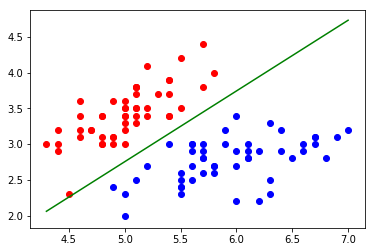

In [28]:
x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = -1 * coef[0] / coef[1] * x_min - intercept / coef[1]
y_max = -1 * coef[0] / coef[1] * x_max - intercept / coef[1]

plt.scatter(X[y==0][:, 0], X[y==0][:, 1], color='red')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='blue')
plt.plot([x_min, x_max], [y_min, y_max], color='green')

# 自力で実装